<a href="https://colab.research.google.com/github/nooraovo/nooraovo.github.io/blob/main/Multi_neuron_exp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## prepare
import torch
import random
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

device=torch.device("cpu")
dtype=torch.float

N,D_in,D_out=1,5,1
# N：input number(=1)
# D_in: input dimension
# D_out: output dimension(=1)

q=3 # relu function
m=3 # hidden dimension(neuron number)

class MyReLU(torch.nn.Module):
    def __init__(self):
        super(MyReLU, self).__init__()
    def forward(self, input):
        input=input.clamp(min=0)
        output=torch.pow(input,q)
        return output

In [12]:
# training case
u=torch.randn(N,D_in,device=device)
u=u/u.norm() # ||u||=1
delta=torch.randn(N,D_in,device=device)
torch.nn.init.normal_(delta, 0, 1)
prob=random.uniform(0,1)
if(prob>0.5):
  x=u + delta
else:
  x=-u + delta

# generate target
v=torch.rand(D_in,D_out,device=device)
v=v/v.norm() # ||v||=1
y=x.mm(v)
layer=MyReLU()
y=layer(y)

loss_1:1.5915344420136535e-07
loss_2:5.421010862427522e-20


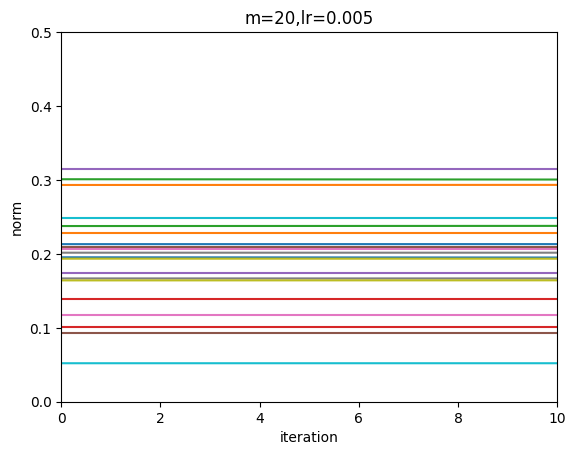

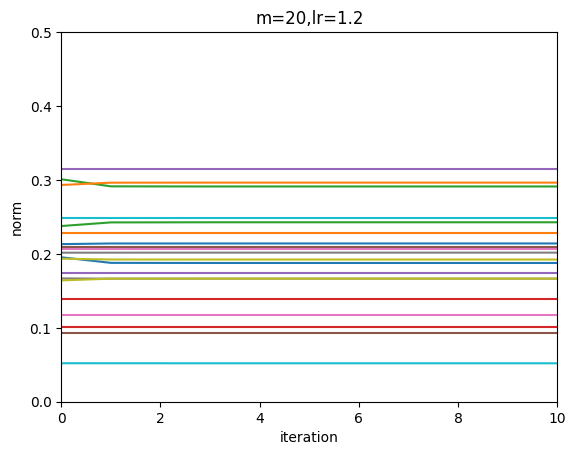

loss_1:1.7098822358008192e-13
loss_2:2.0613393804380653e-17


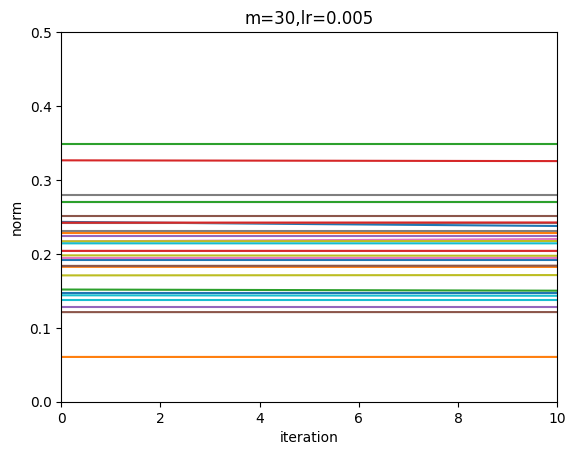

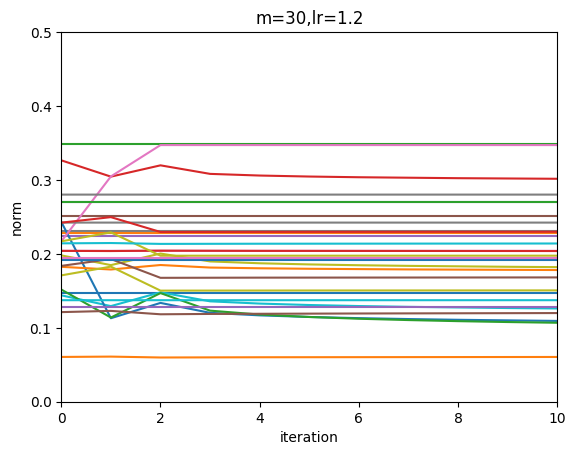

loss_1:1.7408297026122455e-13
loss_2:3.968690288647667e-16


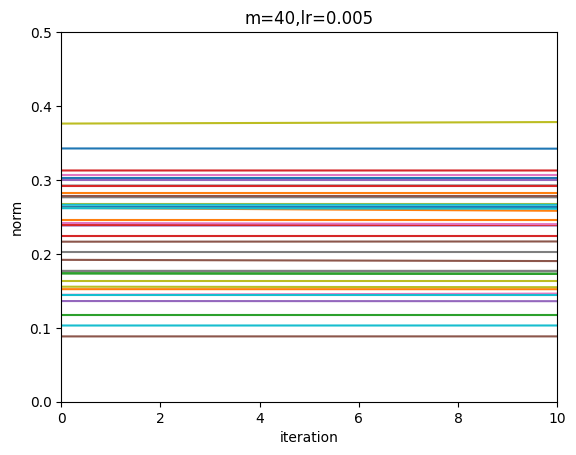

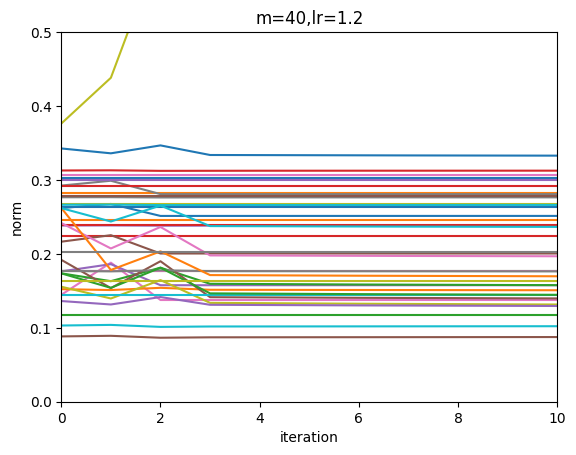

loss_1:9.675940604303435e-14
loss_2:5.4345101335728785e-11


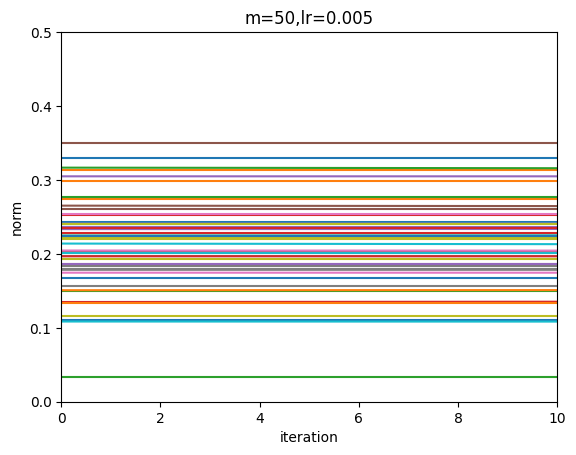

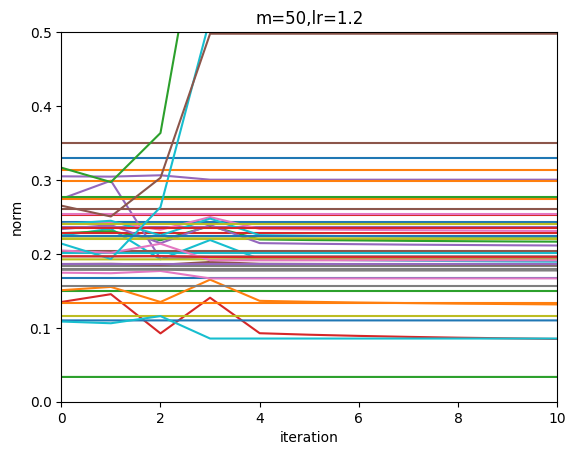

loss_1:1.2490009027033011e-14
loss_2:8.823157997403172e-14


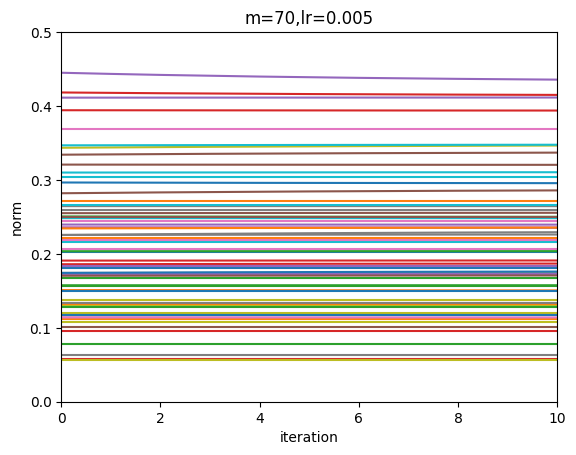

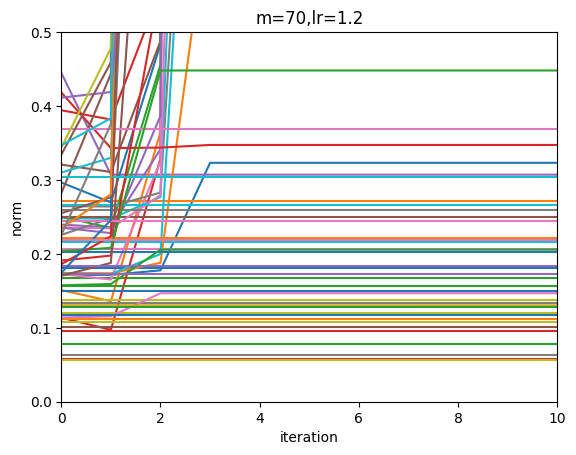

loss_1:3.972169815291693e-14
loss_2:4.8142506869908175e-08


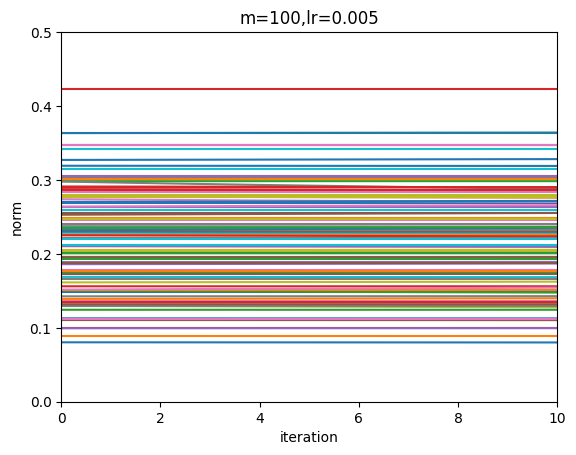

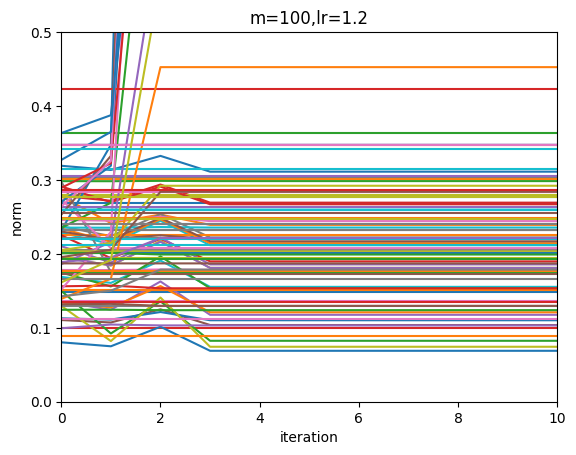

In [13]:
# experiment 2
itr=1000
learning_rate_1=0.005 # small
learning_rate_2=1.2  # large
m_list=[20, 30, 40, 50, 70, 100]
loss_data_1=np.zeros((len(m_list),itr))
loss_data_2=np.zeros((len(m_list),itr))

for i in range(len(m_list)):
  m=m_list[i]
  # record norm change
  norm_list_1=np.zeros((m,itr))
  norm_list_2=np.zeros((m,itr))

  # model for 2 lr
  model_1 = torch.nn.Sequential(
    torch.nn.Linear(D_in,m,bias=False), # w matrix
    MyReLU(),
    torch.nn.Linear(m,D_out,bias=False), # v matrix
  )
  torch.nn.init.normal_(model_1[0].weight, 0, 0.1) # initialize w
  weight_mat1=torch.Tensor(m, D_in).normal_(0, 0.1)
  model_1[0].weight.data=nn.Parameter(weight_mat1)
  torch.nn.init.constant_(model_1[2].weight, 1) # initialize v (half 1 & half -1)
  output_mat1=torch.ones(size=(1,int(m/2)))
  output_mat2=torch.ones(size=(1,int(m/2)))
  output_mat2 *= -1
  output_mat=torch.cat((output_mat1,output_mat2),1)
  model_1[2].weight.data=nn.Parameter(output_mat)

  model_2 = torch.nn.Sequential(
    torch.nn.Linear(D_in,m,bias=False), # w matrix
    MyReLU(),
    torch.nn.Linear(m,D_out,bias=False), # v matrix
  )
  torch.nn.init.normal_(model_2[0].weight, 0, 0.1)
  weight_mat2=weight_mat1.clone()
  model_2[0].weight.data=nn.Parameter(weight_mat2)
  model_2[2].weight.data=nn.Parameter(output_mat)

  # sum up all students
  loss_fn = nn.MSELoss(reduce='sum')

  # begin training
  for it in range(itr):
      #forword pass
      y_hat_1=model_1(x)
      y_hat_2=model_2(x)

      #compute loss
      loss_1 = loss_fn(y_hat_1, y)
      loss_2 = loss_fn(y_hat_2, y)

      # record loss
      loss_data_1[i][it]=loss_1.item()
      loss_data_2[i][it]=loss_2.item()

      # record norm
      for j in range(m):
        norm_list_1[j][it]=model_1[0].weight[j].norm().item()
        norm_list_2[j][it]=model_2[0].weight[j].norm().item()

      # backward propagate
      loss_1.backward()
      loss_2.backward()

      # update student
      with torch.no_grad():
        for param in model_1.parameters():
          param -= learning_rate_1 * param.grad
          break # only update w
        for param in model_2.parameters():
          param -= learning_rate_2 * param.grad
          break # only update w
      model_1.zero_grad()
      model_2.zero_grad()

  # print final loss
  print('loss_1:{0}'.format(loss_1))
  print('loss_2:{0}'.format(loss_2))

  # plot norm change
  fig,ax = plt.subplots()
  for i in range(m):
    ax.plot(norm_list_1[i])
  ax.set_xlabel('iteration')
  ax.set_ylabel('norm')
  plt.xlim(0,10)
  plt.ylim(0,0.5)
  plt.title('m={0},lr={1}'.format(m,learning_rate_1))
  plt.show()

  fig,ax = plt.subplots()
  for i in range(m):
    ax.plot(norm_list_2[i])
  ax.set_xlabel('iteration')
  ax.set_ylabel('norm')
  plt.xlim(0,10)
  plt.ylim(0,0.5)
  plt.title('m={0},lr={1}'.format(m,learning_rate_2))
  plt.show()

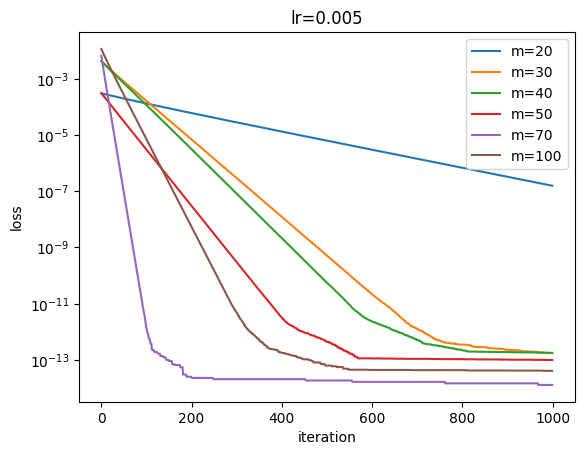

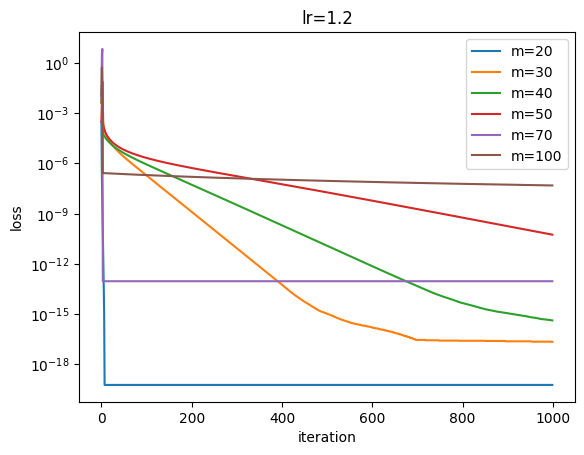

In [14]:
# plot loss change
fig,ax = plt.subplots()
plt.yscale('log')
for i in range(len(m_list)):
  ax.plot(loss_data_1[i],label='m={0}'.format(m_list[i]))
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.legend()
plt.title('lr={0}'.format(learning_rate_1))
plt.show()

fig,ax = plt.subplots()
plt.yscale('log')
for i in range(len(m_list)):
  ax.plot(loss_data_2[i],label='m={0}'.format(m_list[i]))
ax.set_xlabel('iteration')
ax.set_ylabel('loss')
ax.legend()
plt.title('lr={0}'.format(learning_rate_2))
plt.show()